<a href="https://colab.research.google.com/github/Pathway2008/Weblog/blob/main/RFECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Weblog/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Weblog/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Weblog/sample_submission.csv')

In [2]:
train.drop(['sessionID','userID'],axis=1,inplace=True)
test.drop(['sessionID','userID'],axis=1,inplace=True)

In [3]:
import warnings
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
warnings.filterwarnings('ignore')
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
object_columns = train.drop(columns=['TARGET']).select_dtypes(include='object')
for feature in object_columns.columns:
    le = LabelEncoder()

    # Convert the column to string type
    train[feature] = train[feature].astype(str)
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    # Make sure the test set has the same data type
    test[feature] = test[feature].astype(str)

    # Handle unseen labels in the test set
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)

    test[feature] = le.transform(test[feature])

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.8 MB/s eta 0:00:00


In [6]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from math import sqrt
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import RFECV
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               252289 non-null  float64
 1   browser              252289 non-null  int64  
 2   OS                   252289 non-null  int64  
 3   device               252289 non-null  int64  
 4   new                  252289 non-null  int64  
 5   quality              252289 non-null  float64
 6   duration             252289 non-null  float64
 7   bounced              252289 non-null  int64  
 8   transaction          252289 non-null  float64
 9   transaction_revenue  252289 non-null  float64
 10  continent            252289 non-null  int64  
 11  subcontinent         252289 non-null  int64  
 12  country              252289 non-null  int64  
 13  traffic_source       252289 non-null  int64  
 14  traffic_medium       252289 non-null  int64  
 15  keyword          

In [7]:
from sklearn.model_selection import KFold
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [8]:
def rmse_scorer(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [56]:
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [15]:
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)

rfecv = RFECV(estimator=xgb_model, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

# Transform the training and testing sets using only the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Now, you can train your XGBoost model using the selected features
xgb_model.fit(X_train_selected, y_train)
xgb_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
y_pred = xgb_model.predict(X_test_selected)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", rmse)

Selected Features: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'keyword'],
      dtype='object')
xgb_scores: 2.8848577963868527
RMSE: 2.7634728673342157


In [16]:
xgb_model = xgb.XGBRegressor(random_state=43)

rfecv = RFECV(estimator=xgb_model, step=1, cv=kf, scoring='neg_mean_squared_error')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

# Transform the training and testing sets using only the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Now, you can train your XGBoost model using the selected features
xgb_model.fit(X_train_selected, y_train)
xgb_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
y_pred = xgb_model.predict(X_test_selected)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", rmse)

Selected Features: Index(['browser', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'continent', 'subcontinent', 'country', 'traffic_source',
       'keyword'],
      dtype='object')
xgb_scores: 2.9168561335046284
RMSE: 2.8094806047963967


In [17]:
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)

rfecv = RFECV(estimator=xgb_model, step=1, cv=kf, scoring='neg_mean_squared_error')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

# Transform the training and testing sets using only the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Now, you can train your XGBoost model using the selected features
xgb_model.fit(X_train_selected, y_train)
xgb_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
y_pred = xgb_model.predict(X_test_selected)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", rmse)

Selected Features: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'traffic_medium', 'keyword',
       'referral_path'],
      dtype='object')
xgb_scores: 2.8491038194831644
RMSE: 2.745348382572756


In [18]:
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)

rfecv = RFECV(estimator=xgb_model, step=1, cv=kf, scoring='neg_mean_squared_error')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

# Transform the training and testing sets using only the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Now, you can train your XGBoost model using the selected features
xgb_model.fit(X_train_selected, y_train)
xgb_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
y_pred = xgb_model.predict(X_test_selected)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", rmse)

Selected Features: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'traffic_medium', 'keyword',
       'referral_path'],
      dtype='object')
xgb_scores: 2.8491038194831644
RMSE: 2.745348382572756


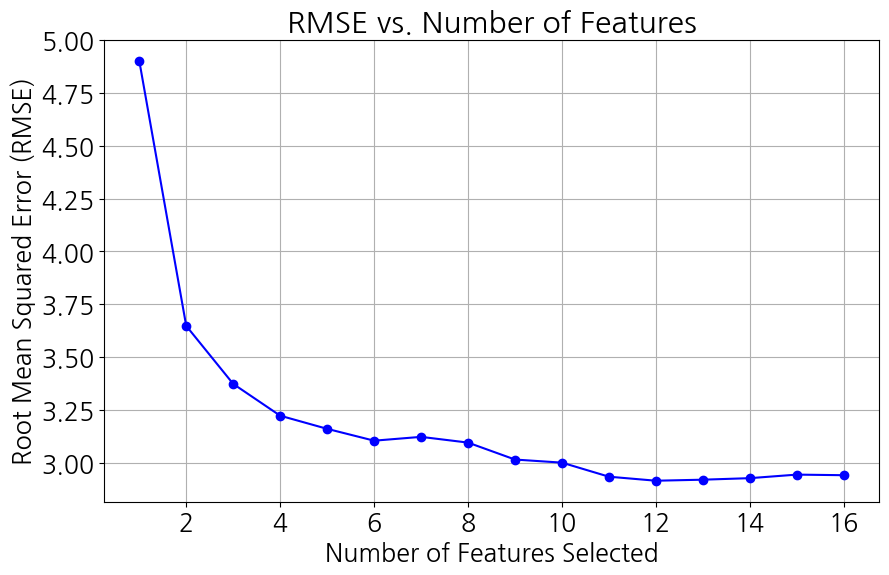

In [39]:
rfecv = RFECV(estimator=xgb_model, step=1, cv=kf, scoring='neg_mean_squared_error')

rfecv.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         np.sqrt(-rfecv.cv_results_['mean_test_score']),
         marker='o', linestyle='-', color='b')
plt.title('RMSE vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

In [40]:
rfecv.support_.sum()

12

In [41]:
selected_features_indices = np.where(rfecv.support_)[0]
selected_features_names = X.columns[selected_features_indices]

# Print the names of the selected features
print("Names of Selected Features:", selected_features_names)

Names of Selected Features: Index(['browser', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'continent', 'subcontinent', 'country', 'traffic_source',
       'keyword'],
      dtype='object')


In [63]:
xgb_model.fit(X_train, y_train)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_predictions = xgb_model.predict(X_test)
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

In [62]:
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", xgb_rmse)

xgb_scores: 2.93554211897225
RMSE: 2.7571927400281675


In [64]:
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", xgb_rmse)

xgb_scores: 2.8491038194831644
RMSE: 2.745348382572756


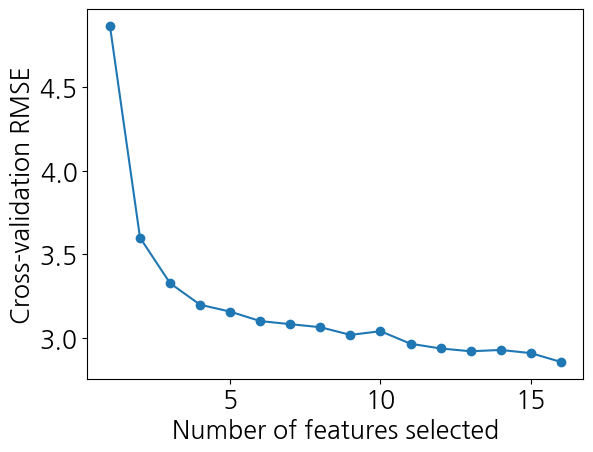

Optimal number of features: 16
Test RMSE on selected features: 2.745348382572756


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming you have already defined X, y, and split the data into train and test sets
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)

# Create the RFECV model
rfecv = RFECV(estimator=xgb_model, step=1, scoring='neg_mean_squared_error', cv=kf)
rfecv.fit(X_train, y_train)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation RMSE")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), np.sqrt(-rfecv.cv_results_['mean_test_score']), marker='o', linestyle='-')
plt.show()

# Print the optimal number of features
optimal_num_features = rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

# Use the selected features for training and testing
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Train the XGBoost model on the selected features
xgb_model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = xgb_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE on selected features: {rmse}")

In [78]:
rfecv.support_.sum()

14

In [81]:
selected_features_indices = np.where(rfecv.support_)[0]
selected_features_names = X.columns[selected_features_indices]
selected_features_names

Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'keyword'],
      dtype='object')

In [93]:
xgb_model.fit(X_train.drop(['device', 'transaction', 'traffic_medium'],axis=1), y_train)
xgb_scores = cross_val_score(xgb_model, X_train.drop(['device', 'transaction', 'traffic_medium'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_predictions = xgb_model.predict(X_test.drop(['device', 'transaction', 'traffic_medium'],axis=1))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

In [83]:
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", xgb_rmse)

xgb_scores: 2.8848577963868527
RMSE: 2.7634728673342157


In [86]:
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", xgb_rmse)

xgb_scores: 2.8491038194831644
RMSE: 2.745348382572756


In [92]:
#'device', 'subcontinent', 'keyword'
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", xgb_rmse)

xgb_scores: 2.8544205391339
RMSE: 2.7550007033393524


In [94]:
#'device', 'transaction', 'traffic_medium'
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", xgb_rmse)

xgb_scores: 2.8842926588142146
RMSE: 2.7609070243830485


In [12]:
#grid
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)
xgb_rmse

2.745348382572756

In [13]:
xgb_model = xgb.XGBRegressor(
    random_state=43,
    reg_lambda=4,
    learning_rate=0.2,
    max_depth=4,
    n_estimators=100
)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)
xgb_rmse

2.76883137114815

In [14]:
from sklearn.model_selection import GridSearchCV

# Assuming you have already defined X_train, y_train, and X_test

# Define the parameter grid with fixed reg_lambda and additional parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'reg_lambda' : [3, 4, 5, 6]
}

# Define the XGBoost model with fixed reg_lambda and GPU acceleration
xgb_model = xgb.XGBRegressor(random_state=43, tree_method='gpu_hist', gpu_id=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding RMSE
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Use the best model to make predictions on the test set
best_xgb_predictions = best_xgb_model.predict(X_test)

# Calculate the RMSE on the test set
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, best_xgb_predictions))
print(f"Test RMSE with best parameters: {best_xgb_rmse}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 3}
Test RMSE with best parameters: 2.7675013711780148


#lgb

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 15
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

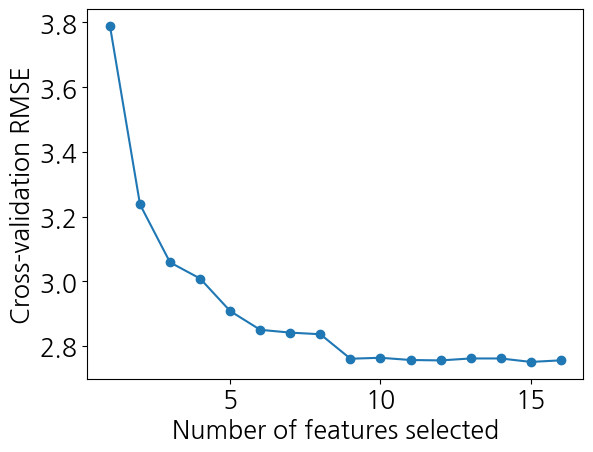

Optimal number of features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 15
[LightGBM] [Info] Start training from score 3.593011


In [116]:
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
# Create the RFECV model with LGBMRegressor
rfecv = RFECV(estimator=lgb_model, step=1, scoring='neg_mean_squared_error', cv=kf)
rfecv.fit(X_train, y_train)

# Visualize the results
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation RMSE")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), np.sqrt(-rfecv.cv_results_['mean_test_score']), marker='o', linestyle='-')
plt.show()

# Print the optimal number of features
optimal_num_features = rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

# Use the selected features for training and testing
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Train the LGBM model on the selected features
lgb_model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = lgb_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [118]:
rfecv_scores = cross_val_score(rfecv, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 113024, number of used features: 16
[LightGBM] [Info] Start training from score 3.592573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 113024, number of used features: 15
[LightGBM] [Info] Start training from score 3.592573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [121]:
rfecv_scores

array([2.5821706 , 2.66230612, 3.02552239, 2.66967386, 2.8455466 ])

In [117]:
#1
selected_features_indices = np.where(rfecv.support_)[0]
selected_features_names = X.columns[selected_features_indices]
rfecv.support_.sum(),selected_features_names,rmse #drop bounced

(15,
 Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'transaction',
        'transaction_revenue', 'continent', 'subcontinent', 'country',
        'traffic_source', 'traffic_medium', 'keyword', 'referral_path'],
       dtype='object'),
 2.7790394541420764)

In [105]:
train.columns

Index(['TARGET', 'browser', 'OS', 'device', 'new', 'quality', 'duration',
       'bounced', 'transaction', 'transaction_revenue', 'continent',
       'subcontinent', 'country', 'traffic_source', 'traffic_medium',
       'keyword', 'referral_path'],
      dtype='object')

In [15]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Assuming you have already defined X_train, y_train, and X_test

# Define the parameter grid for LightGBM
param_grid_lgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}

# Define the LGBM model
lgb_model = LGBMRegressor(random_state=43)

# Create the GridSearchCV object for LGBM
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the data for LGBM
grid_search_lgb.fit(X_train, y_train)

# Print the best parameters and the corresponding RMSE for LGBM
best_params_lgb = grid_search_lgb.best_params_
print(f"Best parameters for LGBM: {best_params_lgb}")

# Get the best model from the grid search for LGBM
best_lgb_model = grid_search_lgb.best_estimator_

# Use the best model to make predictions on the test set for LGBM
best_lgb_predictions = best_lgb_model.predict(X_test)

# Calculate the RMSE on the test set for LGBM
best_lgb_rmse = np.sqrt(mean_squared_error(y_test, best_lgb_predictions))
print(f"Test RMSE with best parameters for LGBM: {best_lgb_rmse}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [18]:
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)
lgb_rmse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

2.7743799222694636

In [22]:
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
lgb_model.fit(X_train.drop(['bounced'],axis=1), y_train)
lgb_predictions = lgb_model.predict(X_test.drop(['bounced'],axis=1))
lgb_scores = cross_val_score(lgb_model, X_train.drop(['bounced'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)
lgb_rmse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 15
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 15
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

2.7790394541420764

# Voting

In [95]:
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [96]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

#cat
cat_model = CatBoostRegressor(random_seed=43, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [97]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train, y_train)

voting_predictions = voting_regressor.predict(X_test)

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [98]:
rfecv = RFECV(estimator=voting_regressor, step=1, scoring='neg_mean_squared_error', cv=kf)
rfecv.fit(X_train, y_train)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation RMSE")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), np.sqrt(-rfecv.cv_results_['mean_test_score']), marker='o', linestyle='-')
plt.show()

# Print the optimal number of features
optimal_num_features = rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

# Use the selected features for training and testing
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Train the XGBoost model on the selected features
xgb_model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = xgb_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE on selected features: {rmse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406


ValueError: when `importance_getter=='auto'`, the underlying estimator VotingRegressor should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
selected_features_indices = np.where(rfecv.support_)[0]
selected_features_names = X.columns[selected_features_indices]
rfecv.support_.sum(),selected_features_names

In [101]:
from sklearn.feature_selection import SelectFromModel

# Assuming you have already defined X, y, and split the data into train and test sets

# Create the VotingRegressor with base models
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model), ('lgb', lgb_model), ('et', et_model), ('rf', rf_model)])

# Create a Pipeline with SelectFromModel and VotingRegressor
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=voting_regressor)),
    ('voting_regressor', voting_regressor)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Visualize the results
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation RMSE")
plt.plot(range(1, len(pipeline.named_steps['voting_regressor'].estimators_) + 1),
         np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')), marker='o', linestyle='-')
plt.show()

# Print the optimal number of features
optimal_num_features = np.sum(pipeline.named_steps['feature_selection'].get_support())
print(f"Optimal number of features: {optimal_num_features}")

# Use the selected features for training and testing
X_train_selected = pipeline.named_steps['feature_selection'].transform(X_train)
X_test_selected = pipeline.named_steps['feature_selection'].transform(X_test)

# Evaluate the model on the test set
voting_predictions = pipeline.predict(X_test_selected)
voting_rmse = np.sqrt(mean_squared_error(y_test, voting_predictions))
print(f"Test RMSE on selected features: {voting_rmse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011


ValueError: when `importance_getter=='auto'`, the underlying estimator VotingRegressor should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.